In [1]:
import os
import scanpy as sc
import unitvelo as utv
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.sparse import issparse

import scvelo as scv


ModuleNotFoundError: No module named 'unitvelo'

In [2]:
import unitvelo

In [3]:
def unitvelo_pipeline_without_smoothing(adata0, name):
    adata = adata0.copy()
    sc.pp.neighbors(adata)
    sc.tl.louvain(adata)
    os.system("mkdir -p TEMP_UNITVELO_OBJECT")
    adata.write_h5ad("TEMP_UNITVELO_OBJECT.h5ad")
    label='louvain'
    velo_config = utv.config.Configuration()
    velo_config.R2_ADJUST = False
    velo_config.VGENES = list(adata.var_names)
    velo_config.IROOT = None
    velo_config.FIT_OPTION = '1'
    velo_config.AGENES_R2 = 1
    velo_config.MIN_SHARED_COUNTS = 0
    velo_config.N_TOP_GENES = len(adata0.var_names)
    velo_config.N_PCs = 50
    velo_config.RESCALE_DATA = True
    velo_config.ASSIGN_POS_U = True

    velo_config.USE_RAW = True # only difference  
    
    adata = utv.run_model("TEMP_UNITVELO_OBJECT.h5ad", label, config_file=velo_config)
    
    V = adata.layers['velocity']
    V = V.A if issparse(V) else V
    V = np.nan_to_num(V, nan=0, neginf=0, posinf=0)
    
    os.system("rm TEMP_UNITVELO_OBJECT.h5ad")
    os.system("rm -r TEMP_UNITVELO_OBJECT")
    return V

In [4]:
adata0 = sc.read_h5ad('../../data/benchmarking/dentategyrus.h5ad')
adata0

AnnData object with n_obs × n_vars = 2272 × 3000
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    var: 'n_counts'
    uns: 'clusters_colors', 'raw_spliced_counts', 'raw_unspliced_counts'
    obsm: 'X_pca', 'X_pca_smooth', 'X_umap'
    layers: 'ambiguous', 'spliced', 'total', 'unspliced'

------> Manully Specified Parameters <------
MIN_SHARED_COUNTS:	0
N_TOP_GENES:	3000
USE_RAW:	True
ASSIGN_POS_U:	True
R2_ADJUST:	False
VGENES:	['H2afy2', 'Tmx2', 'Snrnp70', 'Hist2h2bb', 'Megf8', 'Gripap1', 'Atcay', 'Brcc3', '4933427D14Rik', 'Esyt3', 'Anapc10', 'Txn1', 'Tnrc6b', 'Rps12', 'Kif2c', 'Cfl1', 'Col9a2', '6330408A02Rik', 'Mmgt1', 'Gmpr', 'Psmc6', 'Adprhl2', 'Bax', 'Gtf2e2', 'Cltc', 'Dcp1a', 'Acat2', 'Lsm2', 'Slc27a4', 'Usp51', 'Rpl5', 'Hnrnpa1', 'Ncapd3', 'Elmo1', 'Tm2d3', 'A830080D01Rik', 'Rps7', 'Itm2a', 'Taf13', 'Ncoa6', 'Eno3', 'Golga7b', 'Dnttip1', 'Spice1', 'Fam214b', 'Mavs', 'Eif2b3', 'Kalrn', 'A730017C20Rik', 'Myt1', 'Tpm3', 'Zfp703', 'Mkrn3', 'Dnal4', 'Ninj1', 'Cadm4', 'Slc1a3', 'Marc2', 'Ocrl', 'Thap7', 'Cplx1', 'Ppp1r7', 'Map7d1', 'Serp1', 'Cited2', 'Gm12056', 'Agfg2', '3110082I17Rik', 'Tmem55b', 'Cntn3', 'Spint2', 'Fmnl2', 'Dnajc14', 'Pik3c2b', 'Zc3h10', 'Pex2', 'Bid', 'Ptpre', 'Lmo2', 'Larp4b', 'Ccnt1', 'Cd63', 'Tsc1', 'Flt3', 'Tenm1', 'Galnt14', 'Cd81', 'Nudt3', '

Normalized count data: X.
Extracted 3000 highly variable genes.
Extracted 3000 highly variable genes.
Computing moments for 3000 genes with n_neighbors: 30 and n_pcs: 30
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)

# of velocity genes 80 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 19789.471, (Spliced): 8872.314, (Unspliced): 10917.157: 100%|█████████▉| 11999/12000 [55:10<00:00,  2.82it/s]   

Hecw1


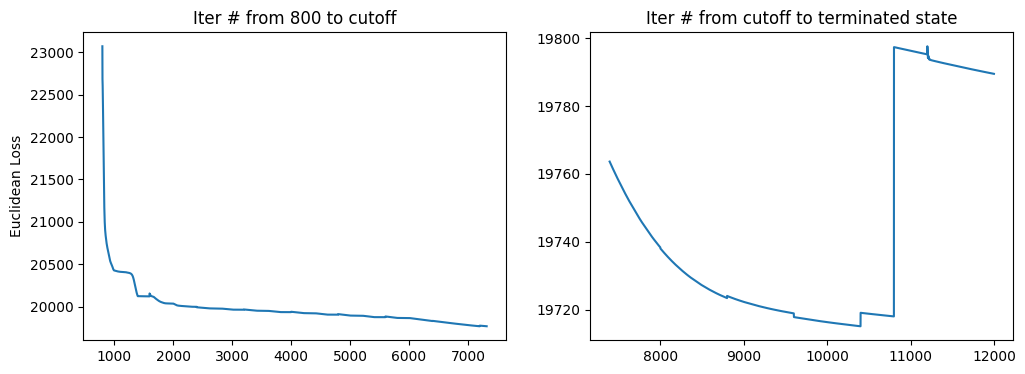

Loss (Total): 19789.471, (Spliced): 8872.314, (Unspliced): 10917.157: 100%|█████████▉| 11999/12000 [55:30<00:00,  3.60it/s]

Total loss 19715.155, vgene loss 19789.471



/camp/home/maizelr/.local/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/2272 [00:00<?, ?cells/s]

In [5]:
V = unitvelo_pipeline_without_smoothing(adata0, '')

In [6]:
adata0.layers['velocity'] = V

In [7]:
def project_to_pca(adata):
    X = adata.layers['total']
    V = adata.layers['velocity']

    X = np.array(X.A if issparse(X) else X)
    V = np.array(V.A if issparse(V) else V)
    V = np.nan_to_num(V, nan=0, neginf=0, posinf=0)
    Y = np.clip(X + V, 0, 1000)


    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)

    Ylog = np.log1p(Y)
    Ypca = pca.transform(Ylog)
    V = Ypca - Xpca
    return V


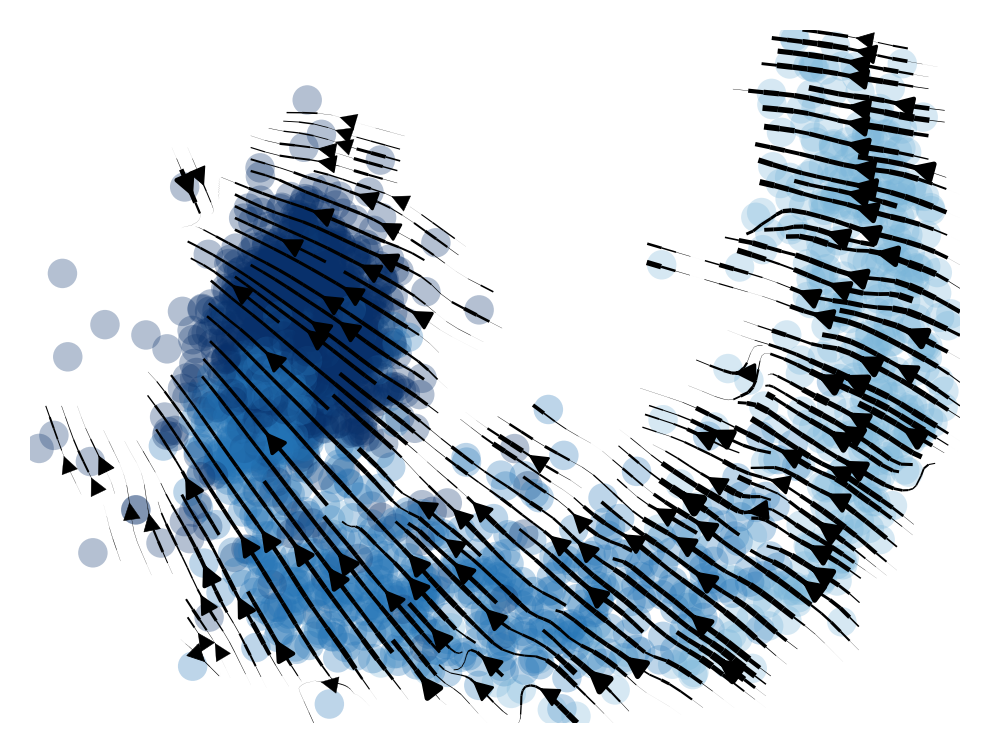

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

adata0.layers['velocity'] = V
adata0.obsm['velocity_pca'] = project_to_pca(adata0)
adata0.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

adata0.uns["velocity_params"] = {'embeddings':'pca'}
scv.pl.velocity_embedding_stream(
    adata0, 
    basis='pca', 
    title="",
    color='clusters', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,2'
)
plt.savefig('../../figures/2.2.4_unitvelo_demo.png', transparent=True)

plt.show()

# Now, testing Svelvet with gamma variation!

In [2]:
import os
import scanpy as sc
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

import scvelo as scv


from sklearn.decomposition import PCA
from scvelo.core import LinearRegression as scveloLR
import matplotlib.pyplot as plt

from torch import nn


In [2]:
import torch
import velvet as vt

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
adata0 = sc.read_h5ad('../../data/benchmarking/gastrulation_erythroid.h5ad')
adata0

AnnData object with n_obs × n_vars = 9815 × 2915
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'n_counts'
    uns: 'celltype_colors', 'raw_spliced_counts', 'raw_unspliced_counts'
    obsm: 'X_pca', 'X_pca_smooth', 'X_umap'
    varm: 'precomputed_PCs'
    layers: 'spliced', 'total', 'unspliced'

In [4]:
def project_to_pca(adata):
    X = adata.layers['total']
    V = adata.layers['velocity']

    X = np.array(X.A if issparse(X) else X)
    V = np.array(V.A if issparse(V) else V)
    V = np.nan_to_num(V, nan=0, neginf=0, posinf=0)
    Y = np.clip(X + V, 0, 1000)


    Xlog = np.log1p(X)
    pca = PCA()
    Xpca = pca.fit_transform(Xlog)

    Ylog = np.log1p(Y)
    Ypca = pca.transform(Ylog)
    V = Ypca - Xpca
    return V


def velvetsplicing_pipeline(adata0, name, gmin, gmax):
    adata = adata0.copy()
    
    vt.pp.neighborhood(adata, n_neighbors=100)
    
    adata.layers['spliced'] = (adata.layers['spliced'].A if 
                               issparse(adata.layers['spliced']) else 
                               adata.layers['spliced'])
    adata.layers['unspliced'] = (adata.layers['unspliced'].A if 
                               issparse(adata.layers['unspliced']) else 
                               adata.layers['unspliced'])
    adata.layers['total'] = adata.layers['spliced'] + adata.layers['unspliced']
    
    vt.ut.set_seed(0)
        
    vt.md.Svelvet.setup_anndata(adata, x_layer='total', u_layer='unspliced', knn_layer='knn_index')

    model = vt.md.Svelvet(
        adata,
        n_latent = 50,
        linear_decoder = True,
        neighborhood_space="latent_space",
        gamma_mode = "learned",
    )

    model.setup_model(gamma_kwargs={'gamma_min':gmin,'gamma_max':gmax})
    
    model.train(
        batch_size = adata.shape[0],
        max_epochs = 1000, 
        freeze_vae_after_epochs = 200,
        constrain_vf_after_epochs = 200,
        lr=0.001,
    )
    
    V = model.predict_velocity()
    V = V.A if issparse(V) else V
    V = np.nan_to_num(V, nan=0, neginf=0, posinf=0)
    return V

In [5]:
def plot(adata0, V, color, title):
    adata0.layers['velocity'] = V
    adata0.obsm['velocity_pca'] = project_to_pca(adata0)
    adata0.uns["velocity_params"] = {'embeddings':'pca'}

    fig = plt.figure(figsize=(4,3), dpi=300)

    ax = fig.subplots()

    adata0.uns["velocity_params"] = {'embeddings':'pca'}
    scv.pl.velocity_embedding_stream(
        adata0, 
        basis='pca', 
        title=title,
        color=color, 
        show=False,
        ax=ax,
        size=200,
        fontsize=16, 
        legend_loc='on data', components='1,2'
    )
    plt.show()

In [6]:
adata0 = sc.read_h5ad('../../data/benchmarking/dentategyrus.h5ad')
V = velvetsplicing_pipeline(adata0, '', 0.1, 1)    

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].
INFO     Generating sequential column names                                                  


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:44<00:00,  9.75it/s, loss=0.482, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:44<00:00,  9.58it/s, loss=0.482, v_num=1]


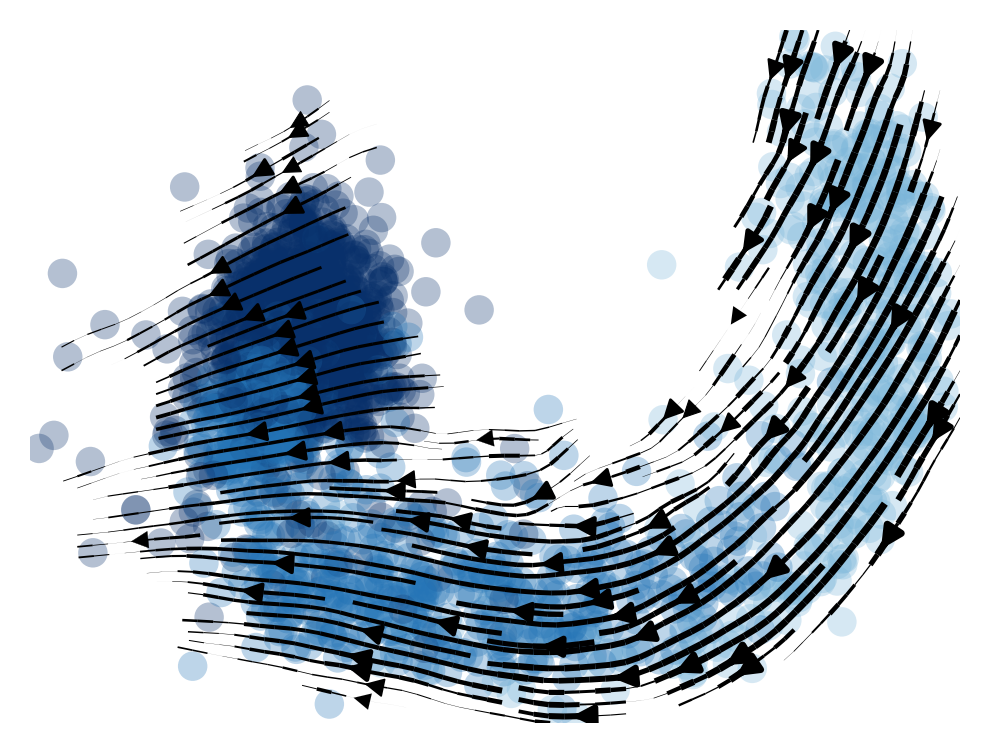

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

adata0.layers['velocity'] = V
adata0.obsm['velocity_pca'] = project_to_pca(adata0)
adata0.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

adata0.uns["velocity_params"] = {'embeddings':'pca'}
scv.pl.velocity_embedding_stream(
    adata0, 
    basis='pca', 
    title="",
    color='clusters', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,2'
)
plt.savefig('../../figures/2.2.4_velvet_othersplicing_default_params.png', transparent=True)

plt.show()

In [9]:
adata0 = sc.read_h5ad('../../data/benchmarking/dentategyrus.h5ad')
V = velvetsplicing_pipeline(adata0, '', 0.01, 1)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].
INFO     Generating sequential column names                                                  


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [00:55<00:00, 18.34it/s, loss=0.425, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s, loss=0.425, v_num=1]


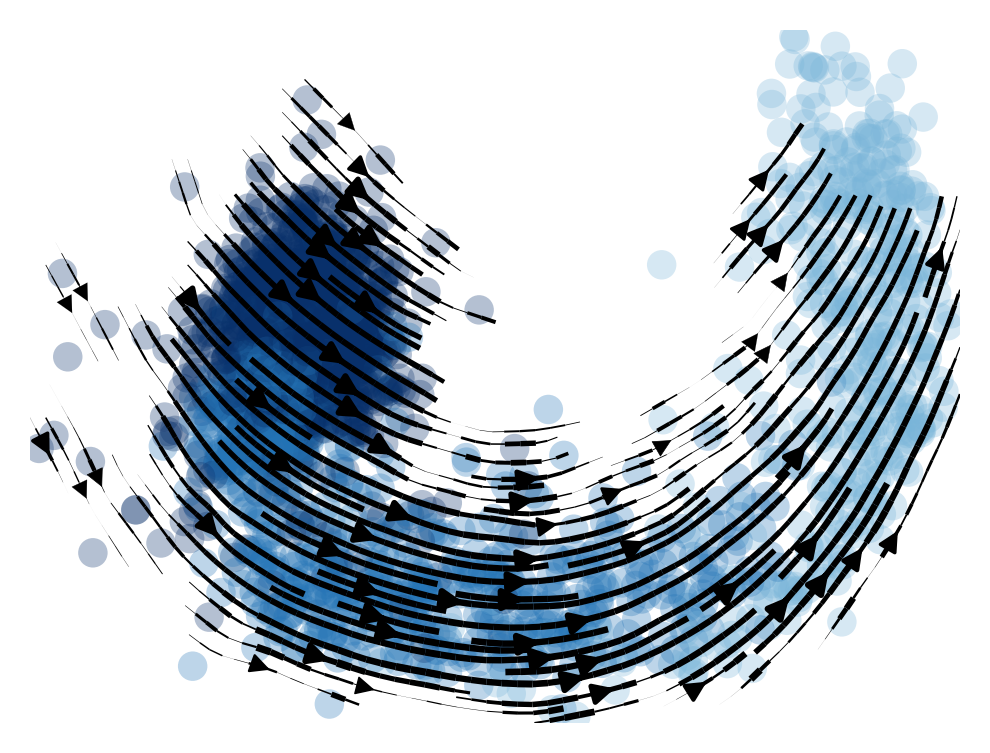

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

adata0.layers['velocity'] = V
adata0.obsm['velocity_pca'] = project_to_pca(adata0)
adata0.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

adata0.uns["velocity_params"] = {'embeddings':'pca'}
scv.pl.velocity_embedding_stream(
    adata0, 
    basis='pca', 
    title="",
    color='clusters', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,2'
)
plt.savefig('../../figures/2.2.4_velvet_othersplicing_other_params.png', transparent=True)

plt.show()

In [11]:
adata0 = sc.read_h5ad('../../data/benchmarking/gastrulation_erythroid.h5ad')
V = velvetsplicing_pipeline(adata0, '', 0.1, 1)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].
INFO     Generating sequential column names                                                  


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:43<00:00,  2.12it/s, loss=0.514, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s, loss=0.514, v_num=1]


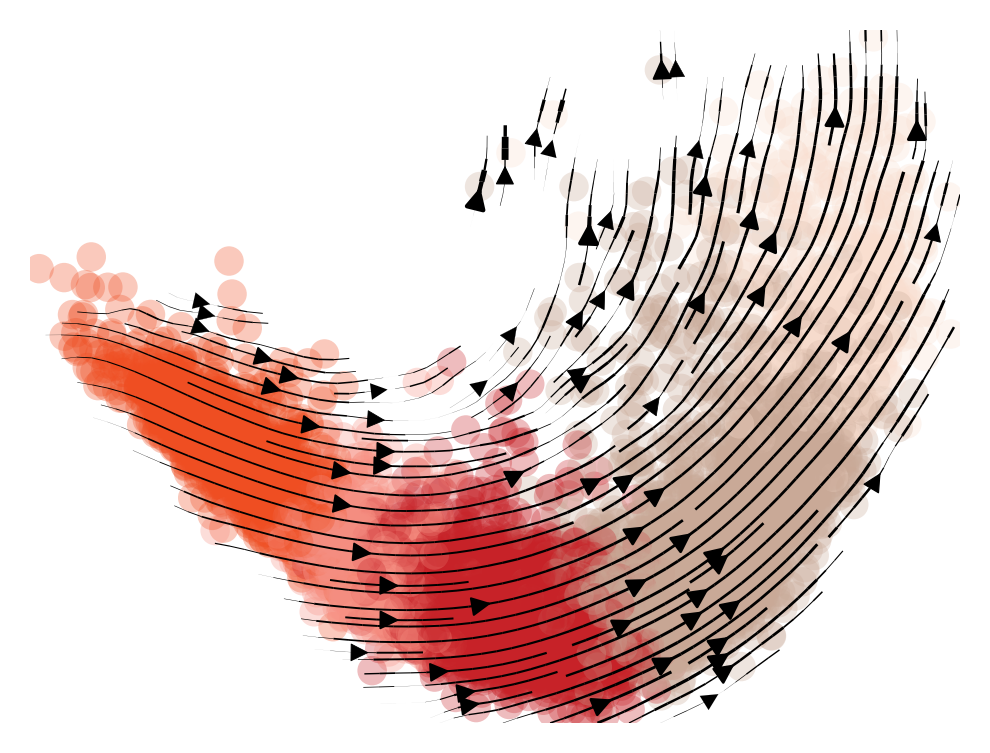

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

adata0.layers['velocity'] = V
adata0.obsm['velocity_pca'] = project_to_pca(adata0)
adata0.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

adata0.uns["velocity_params"] = {'embeddings':'pca'}
scv.pl.velocity_embedding_stream(
    adata0, 
    basis='pca', 
    title="",
    color='celltype', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,2'
)
plt.savefig('../../figures/2.2.4_erythroid_default.png', transparent=True)

plt.show()

In [17]:
adata0 = sc.read_h5ad('../../data/benchmarking/gastrulation_erythroid.h5ad')
V = velvetsplicing_pipeline(adata0, '', 1, 100)

Using ScanPy methods to calculate distances, indices, connectivities, transitions, ... done! 
KNN indices for Velvet stored in .obsm['knn_index'].
Dense similarity transition matrix for Velvet stored in .obsm['Ts'].
INFO     Generating sequential column names                                                  


Multiprocessing is handled by SLURM.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:53<00:00,  2.06it/s, loss=0.485, v_num=1] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [07:53<00:00,  2.11it/s, loss=0.485, v_num=1]


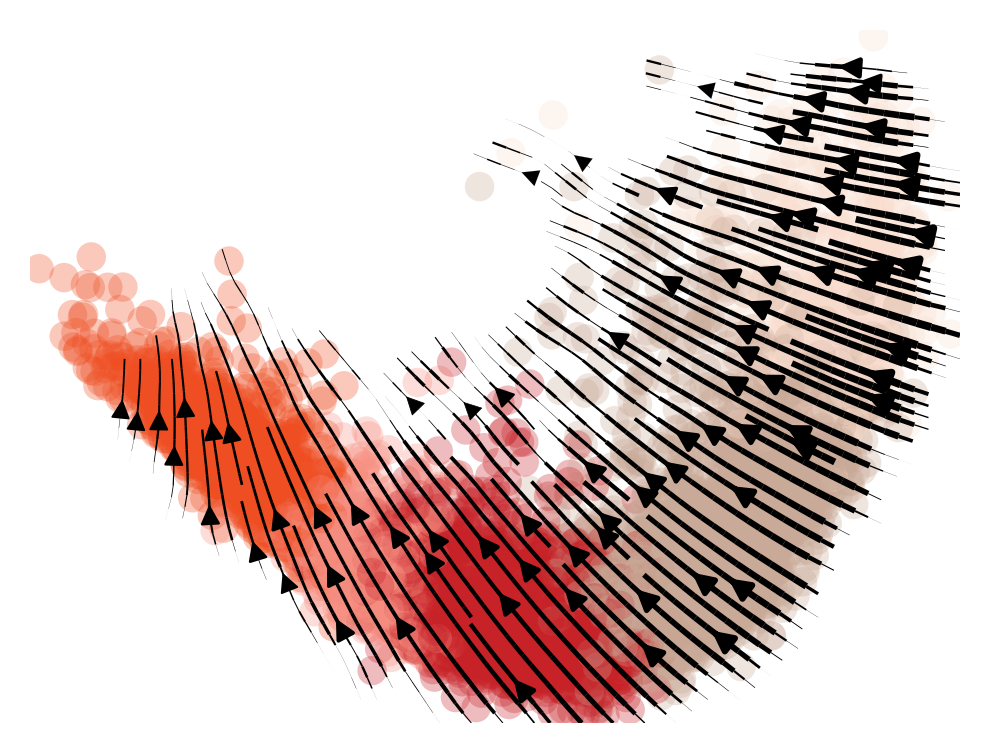

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

adata0.layers['velocity'] = V
adata0.obsm['velocity_pca'] = project_to_pca(adata0)
adata0.uns["velocity_params"] = {'embeddings':'pca'}

fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

adata0.uns["velocity_params"] = {'embeddings':'pca'}
scv.pl.velocity_embedding_stream(
    adata0, 
    basis='pca', 
    title="",
    color='celltype', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc=False, components='1,2'
)
plt.savefig('../../figures/2.2.4_erythroid_other.png', transparent=True)

plt.show()

In [20]:
adata0 = sc.read_h5ad('../../data/benchmarking/dentategyrus.h5ad')
adata0

AnnData object with n_obs × n_vars = 2272 × 3000
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    var: 'n_counts'
    uns: 'clusters_colors', 'raw_spliced_counts', 'raw_unspliced_counts'
    obsm: 'X_pca', 'X_pca_smooth', 'X_umap'
    layers: 'ambiguous', 'spliced', 'total', 'unspliced'

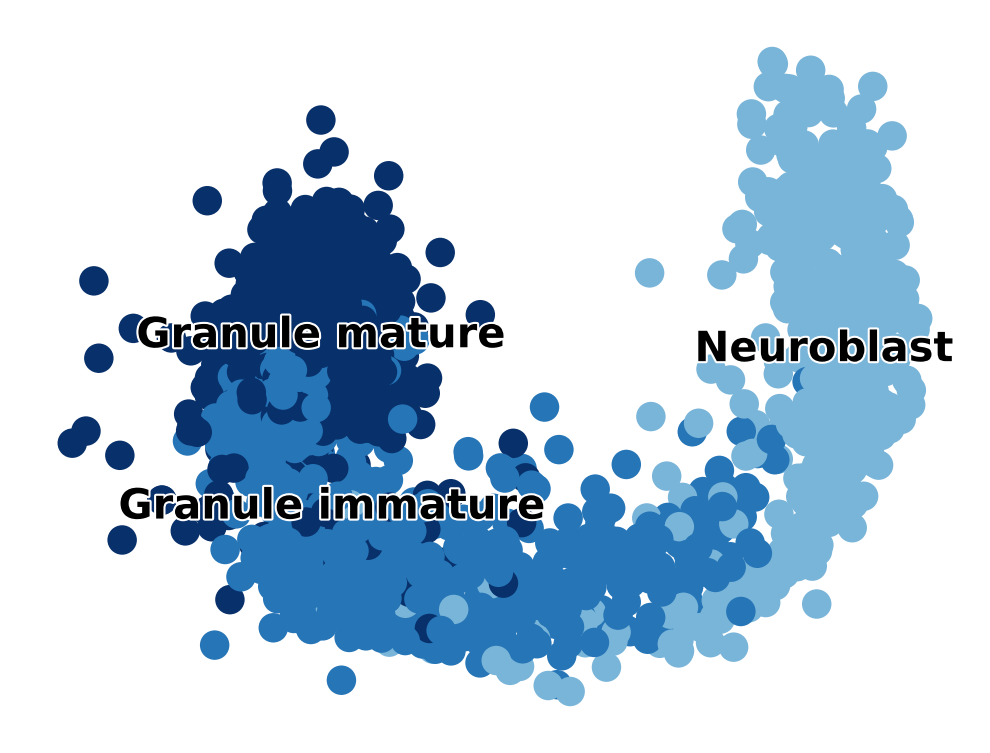

In [23]:
fig = plt.figure(figsize=(4,3), dpi=300)

ax = fig.subplots()

scv.pl.scatter(
    adata0, 
    basis='pca', 
    title="",
    color='clusters', 
    show=False,
    ax=ax,
    size=200,
    fontsize=16, 
    legend_loc='on data', components='1,2'
)

plt.savefig('../../figures/2.2.4_novelo_schematic.png', transparent=True)
plt.show()